In [1]:
from tools import vis, util

import json, imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data
X is a DataFrame with one column, "text".

y is the corresponding topic category.

In [2]:
X, y = util.load_dataset('./processed/reuters.json')

In [3]:
X.head(n=10)

,text
1,BAHIA COCOA REVIEW\n Showers continued throug...
10,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...
100,N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...
1000,NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...
10000,ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...
10002,ISLAND TELEPHONE SHARE SPLIT APPROVED\n &lt;I...
10005,U.K. GROWING IMPATIENT WITH JAPAN - THATCHER\n...
10008,QUESTECH INC &lt;QTEC> YEAR NET\n Shr loss ni...
10011,CANADA OIL EXPORTS RISE 20 PCT IN 1986\n Cana...
10014,"COFFEE, SUGAR AND COCOA EXCHANGE NAMES CHAIRMA..."


## Distribution of classes
**earn** and **acq** are the two biggest classes, we're going to analyze the top 10 classes besides these two

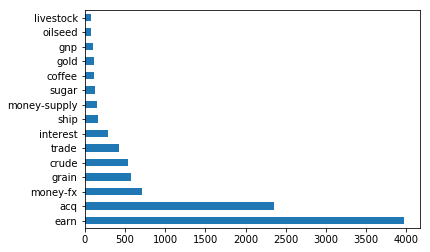

In [4]:
counts = y.value_counts()
counts.iloc[:15].plot.barh(color=plt.cm.tab10(0))
    
# used to select a subset of X and y later based on this bar graph
mask = y.apply(set(counts.index[2:22]).__contains__)

# Create and run the pipeline
This will perform tokenization and counting, then topic modeling and project into 2-D using Isomap

In [5]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import Isomap

X_small = X[mask]
y_small = y[mask]

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10, max_df=.3, stop_words='english')),
    ('tfidf_cp', util.Checkpoint()),
    ('topics', NMF(n_components=30)),
    ('topics_cp', util.Checkpoint()),
    ('norm', Normalizer(norm='l1')),
    ('proj', Isomap())
])

# run the pipeline
pos = pd.DataFrame(pipe.fit_transform(X_small.text), index=X_small.index)

# Visualize
Show keywords from sample documents

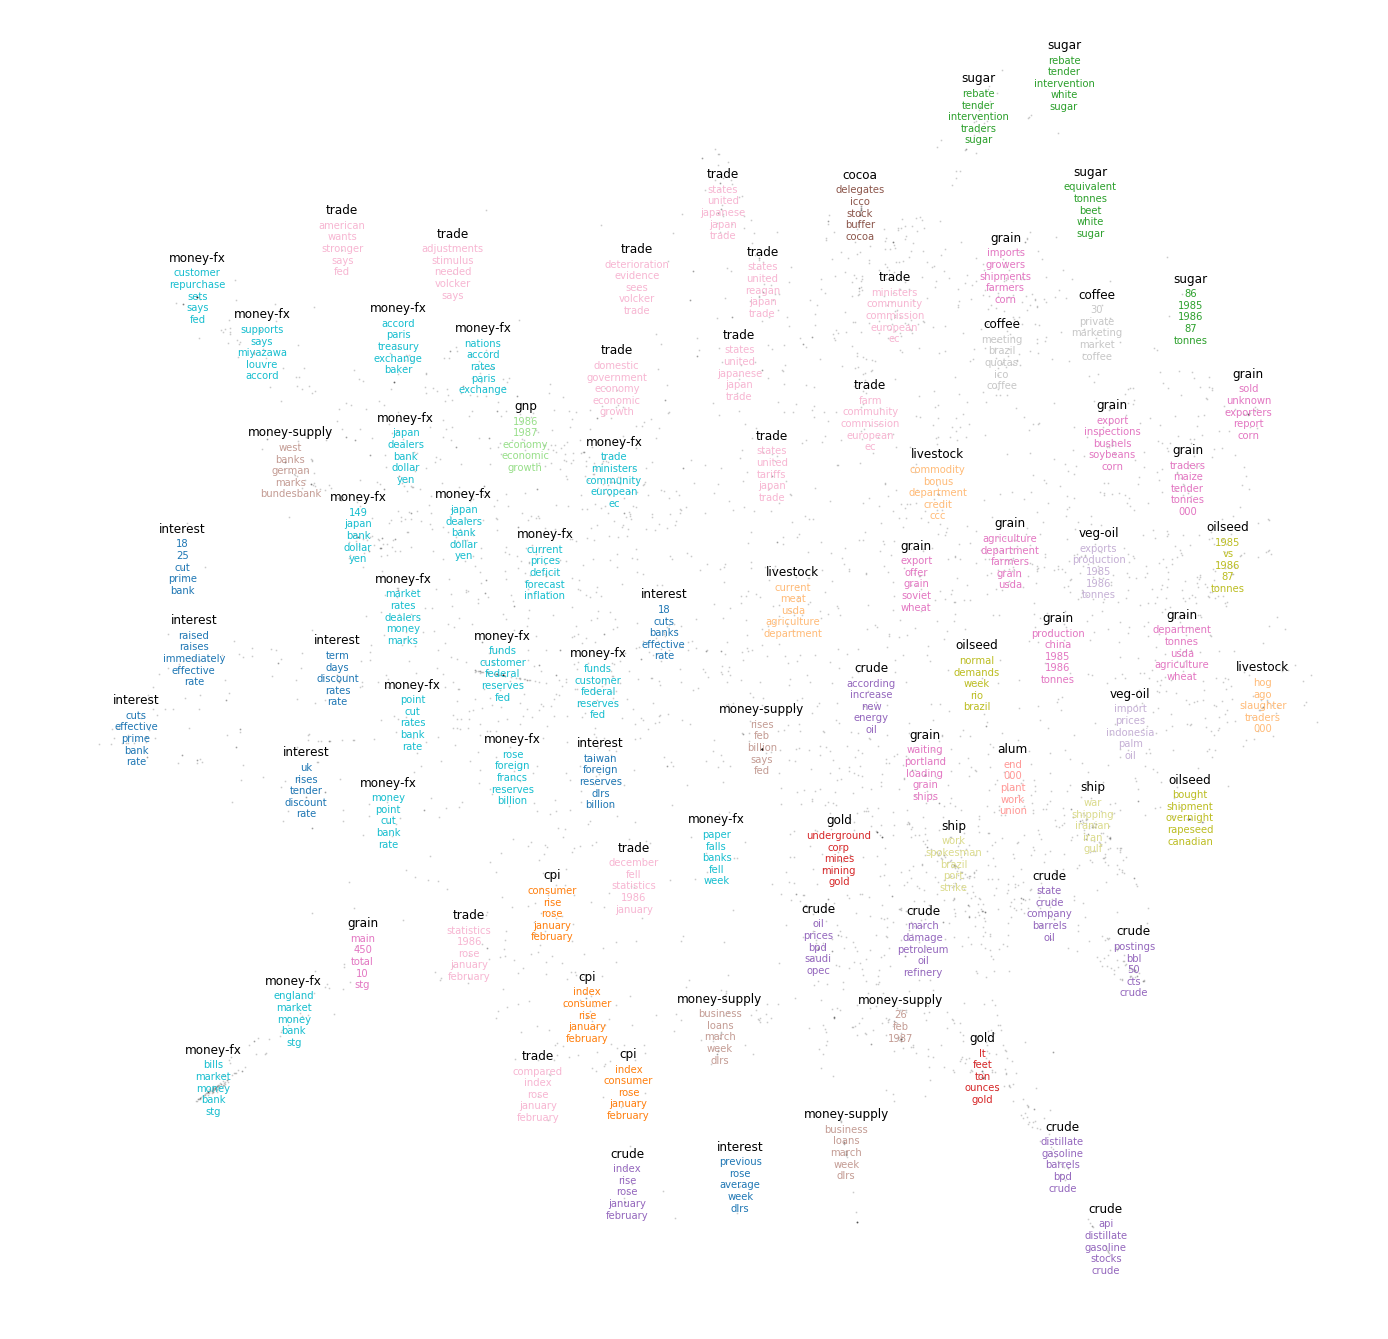

In [6]:
# grab some of the intermediate data from the pipeline
vocab = np.array(pipe.named_steps['tfidf'].get_feature_names())
components = pipe.named_steps['topics'].components_
X_tfidf = pipe.named_steps['tfidf_cp'].X_transform
X_topics = pipe.named_steps['topics_cp'].X_transform.argmax(axis=1)


# figure out keywords for each topic
# takes the keywords occurring in the document from the most important topic from that document
n_keywords = 5
keywords = pd.DataFrame([vocab[sorted(xi.nonzero()[1], key=lambda i: components[j, i])[-n_keywords:]]
                         for xi,j in zip(X_tfidf, X_topics)], index=X_small.index)

colors = {v: plt.cm.tab20(i%20) for i,v in enumerate(set(y_small))}
    
plt.figure(figsize=(24, 24))
plt.axis('off')

for x, ax in vis.subplots_scatter(pos, s=.035, scatter_args=dict(s=1, alpha=.125, c='k')):
    x0 = x[0]
    vis.keywords_plot(keywords.loc[x0].dropna(), y_small.loc[x0], colors)

# Ideas for exploration
* Try looking at subsets, e.g.,
    * Top 3 topics
    * Bottom k
    * Manually selected (e.g., commodities only)
* Try more feature engineering
    * n-Grams
    * adjust TFIDF parameters
* Use a different keywords suggestion heuristic